In [7]:
# Import necessary libraries 
import findspark
findspark.init()

from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# Step 1: Initialize Spark session
spark = SparkSession.builder \
    .appName("CleaningData") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "5g") \
    .config("spark.shuffle.memoryFraction", "0.5") \
    .config("spark.storage.memoryFraction", "0.5") \
    .config("spark.driver.maxResultSize", "0") \
    .getOrCreate()

# Step 2: Define schema for the Netflix dataset

# Netflix schema
netflix_schema = StructType([
    StructField("show_id", StringType(), True),
    StructField("type", StringType(), True),
    StructField("title", StringType(), True),
    StructField("director", StringType(), True),
    StructField("cast", StringType(), True),
    StructField("country", StringType(), True),
    StructField("date_added", StringType(), True),
    StructField("release_year", StringType(), True),
    StructField("rating", StringType(), True),
    StructField("duration", StringType(), True),
    StructField("listed_in", StringType(), True),
    StructField("description", StringType(), True)
])

# Step 3: Load the Netflix dataset from HDFS
netflix_df = spark.read.csv("hdfs://localhost:9000/user/reviews/netflix_titles.csv", 
                            schema=netflix_schema, header=True)

# Step 4: Clean and preprocess the Netflix dataset
netflix_cleaned = netflix_df.dropna(how='any') \
    .withColumn("country", F.trim(F.col("country"))) \
    .withColumn("release_year", F.col("release_year").cast(IntegerType())) \
    .filter(F.col("release_year") >= 2000)

# Step 5: Save the cleaned Netflix dataset back to HDFS
netflix_cleaned.write.csv("hdfs://localhost:9000/user/reviews/cleaned_netflix_titles", 
                          header=True, mode='overwrite')

# Step 6: Display the cleaned data 
netflix_cleaned.show(5)


24/11/08 21:32:33 WARN Utils: Your hostname, dsbda-vm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/11/08 21:32:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/08 21:32:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-------+-------+--------------------+-------------------+--------------------+--------------------+------------------+------------+------+---------+--------------------+--------------------+
|show_id|   type|               title|           director|                cast|             country|        date_added|release_year|rating| duration|           listed_in|         description|
+-------+-------+--------------------+-------------------+--------------------+--------------------+------------------+------------+------+---------+--------------------+--------------------+
|     s9|TV Show|The Great British...|    Andy Devonshire|Mel Giedroyc, Sue...|      United Kingdom|September 24, 2021|        2021| TV-14|9 Seasons|British TV Shows,...|A talented batch ...|
|    s10|  Movie|        The Starling|     Theodore Melfi|Melissa McCarthy,...|       United States|September 24, 2021|        2021| PG-13|  104 min|    Comedies, Dramas|A woman adjusting...|
|    s13|  Movie|        Je Suis Karl|Ch

In [2]:
!pip install hdfs


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 235.8 kB/s eta 0:00:001m595.0 kB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for hdfs: filename=hdfs-2.7.3-py3-none-any.whl size=34321 sha256=f1b061639deb5bef7499a5b381c5d18a2aabfb4dcc2cc6a096b6bd702bdf1f5e
  Stored in directory: /home/ubuntu/.cache/pip/wheels/68/dd/29/c1a590238f9ebbe4f7ee9b3583f5185d0b9577e23f05c990eb
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=ce10b2794fc44b87e4627fb34317eb2f42d1f3af2258f6506e356e0e56188e73
  Stored in directory: /home/ubuntu/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built hdfs docopt
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of 

Data preview:
                       Genre Country  Count
0                       2016   Italy      0
1                       2016  Global      1
2                     98 min   Italy      0
3                     98 min  Global      1
4         Action & Adventure   Italy      4
5         Action & Adventure  Global    672
6             Anime Features   Italy      0
7             Anime Features  Global     58
8               Anime Series   Italy      0
9               Anime Series  Global     10
10          British TV Shows   Italy      0
11          British TV Shows  Global     21
12  Children & Family Movies   Italy      3
13  Children & Family Movies  Global    464
14         Classic & Cult TV   Italy      0
15         Classic & Cult TV  Global      3
16            Classic Movies   Italy      0
17            Classic Movies  Global      1
18                  Comedies   Italy     10
19                  Comedies  Global   1401
20            Crime TV Shows   Italy      2
21            Crim

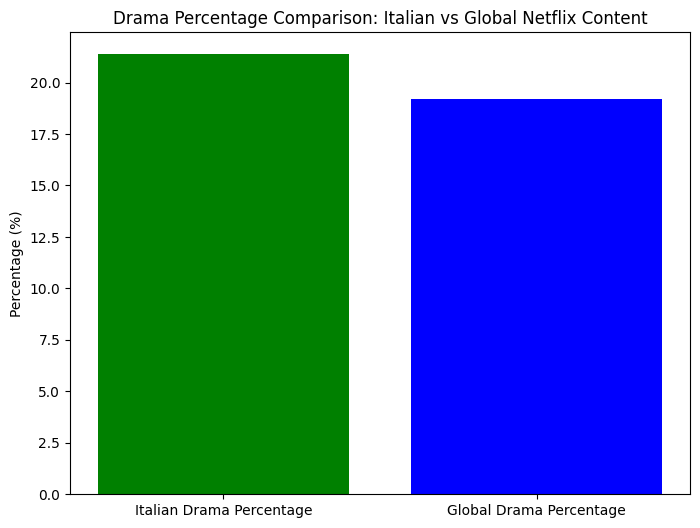

In [4]:
from hdfs import InsecureClient
import pandas as pd
import io
import matplotlib.pyplot as plt

# Connect to HDFS - using `localhost` and `9870
hdfs_client = InsecureClient('http://localhost:9870', user='ubuntu')

# Path to the output file on HDFS
output_file_path = '/user/ubuntu/output/part-00000'

# Read the file directly from HDFS
with hdfs_client.read(output_file_path, encoding='utf-8') as reader:
    # Load into a DataFrame
    data = pd.read_csv(reader, sep='\t', header=None, names=['Genre', 'Country', 'Count'])

# Display the first few rows
print("Data preview:")
print(data.head(50))

# Step 1: Pivot the Data
pivot_data = data.pivot(index='Genre', columns='Country', values='Count').fillna(0).reset_index()

# Step 2: Calculate Total Counts
total_italy_count = pivot_data['Italy'].sum()
total_global_count = pivot_data['Global'].sum()

# Step 3: Calculate Drama Percentages
drama_row = pivot_data[pivot_data['Genre'] == 'Dramas']
italy_drama_count = drama_row['Italy'].values[0] if not drama_row.empty else 0
global_drama_count = drama_row['Global'].values[0] if not drama_row.empty else 0

italian_drama_percentage = (italy_drama_count / total_italy_count) * 100 if total_italy_count > 0 else 0
global_drama_percentage = (global_drama_count / total_global_count) * 100 if total_global_count > 0 else 0

print(f"Italian Drama Percentage: {italian_drama_percentage:.2f}%")
print(f"Global Drama Percentage: {global_drama_percentage:.2f}%")

# Step 4: Visualization 
percentages = [italian_drama_percentage, global_drama_percentage]
labels = ['Italian Drama Percentage', 'Global Drama Percentage']

plt.figure(figsize=(8,6))
plt.bar(labels, percentages, color=['green', 'blue'])
plt.title('Drama Percentage Comparison: Italian vs Global Netflix Content')
plt.ylabel('Percentage (%)')
plt.show()


In [6]:
from scipy.stats import chi2_contingency

# Create a contingency table
# Assuming `italy_drama_count`, `total_italy_count`, `global_drama_count`, and `total_global_count` are already defined
# Non-drama counts are the total count minus the drama count for each group
italy_non_drama_count = total_italy_count - italy_drama_count
global_non_drama_count = total_global_count - global_drama_count

# Contingency table format:
# [[Italy Drama, Italy Non-Drama], [Global Drama, Global Non-Drama]]
contingency_table = [
    [italy_drama_count, italy_non_drama_count],
    [global_drama_count, global_non_drama_count]
]

# Perform Chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Display the test result with 4 decimal places
print(f"Chi-square value: {chi2:.4f}")
print(f"P-value: {p:.4f}")

# Interpret the p-value
alpha = 0.05
if p < alpha:
    print("The difference in drama proportions is statistically significant.")
else:
    print("The difference in drama proportions is not statistically significant.")



Chi-square value: 0.2601
P-value: 0.6101
The difference in drama proportions is not statistically significant.
